This tests the napari_jflowcyte gating package.  The code reads an FCS file (via importflowcyte) then displays it interactively in napari.  Gate drawing consists of Napari polygons which are read back into python and turned into plot coordinates.  Gating is then accomplished with the gateflowcyte script and files are exported with exportflowcyte.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import numpy as np
import pandas as pd
import napari
from magicgui import magicgui
%gui qt
import sys
sys.path.append('../')
import importflowcyte
import exportflowcyte
import importpw
import gateflowcyte as gfc

In [2]:
chnames,data,meta=importflowcyte.getFCSFile('H7.fcs')

FCS3.0
[58, 3260, 3261, 4975500, 0, 0]


In [3]:
fcsdf=pd.DataFrame(data.T)
fcsdf.columns=chnames
fcsdf.head()

,T0,T1,INFO,FS00-H,FS00-A,FS00-W,FS01-H,FS01-A,FS01-W,SS02-H,...,FL10-H,FL10-A,FL10-W,FL13-H,FL13-A,FL13-W,FL17-H,FL17-A,FL17-W,TIME
0,1.271600e+09,23.0,56890112.0,132470528.0,172975104.0,806780928.0,7.830218e+08,1.185355e+09,9.914941e+08,157025536.0,...,3738368.0,4.301302e+06,693501952.0,5252352.0,5879040.0,633536512.0,560128.0,475904.0,459767808.0,204406656.0
1,1.271604e+09,23.0,56890112.0,193982464.0,230758912.0,722862080.0,7.621455e+08,1.163070e+09,1.021247e+09,144043776.0,...,239104.0,2.628325e+05,374505472.0,302336.0,194048.0,174456832.0,480768.0,489984.0,457015296.0,204406672.0
2,1.271616e+09,23.0,56890112.0,220672256.0,281977088.0,779747328.0,1.041519e+09,1.599409e+09,9.946399e+08,217775872.0,...,1695232.0,1.773067e+06,684359680.0,2685184.0,2742784.0,643399680.0,526848.0,724480.0,725385216.0,204406672.0
3,1.271616e+09,23.0,56890112.0,189160960.0,223701248.0,718209024.0,8.974874e+08,1.346793e+09,1.020068e+09,102217472.0,...,486144.0,4.242165e+05,372998144.0,815872.0,950272.0,638189568.0,493312.0,540672.0,393576448.0,204406672.0
4,1.271623e+09,23.0,56890112.0,262222336.0,329283584.0,777781248.0,1.106833e+09,1.533192e+09,7.985889e+08,336620544.0,...,10863104.0,1.189590e+07,667189248.0,14011904.0,16138240.0,707133440.0,784128.0,1099520.0,710082560.0,204406704.0


In [4]:
fcsdf['FRET']=fcsdf['FL04-A']/fcsdf['FL10-A']
fcsdf['Acceptor']=fcsdf['FL10-A']/1000000.0

In [5]:
def drawHist(df,xcol,ycol,limits,logs,binSize=4,figsize=(4,4)):
    fig=Figure(figsize=figsize,dpi=300)
    #canvas=FigureCanvasAgg(fig)
    histbins=importpw.get2DHistBins(binSize=binSize,xMin=limits[0],xMax=limits[1],yMin=limits[2],yMax=limits[3],logx=logs[0],logy=logs[1])
    counts,_,_=np.histogram2d(df[xcol],df[ycol],histbins)
    cmap=importpw.getNiceColormap(True)
    marg=0.15
    width=1.0-2.0*marg
    height=1.0-2.0*marg
    #ax=fig.gca()
    ax=fig.add_axes([marg,marg,width,height])
    ax.pcolormesh(histbins[0],histbins[1],counts.T,cmap=cmap)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol,labelpad=-5)
    ax.axis([limits[0],limits[1],limits[2],limits[3]])
    if logs[0]: ax.set_xscale('log')
    if logs[1]: ax.set_yscale('log')
    #ax.margins(x=0.05,y=0.05,tight=True)
    #plt.subplots_adjust(left=marg,right=(1.0-marg),top=(1.0-marg),bottom=marg)
    #ax.yaxis.label_pad=-10
    canvas=FigureCanvasAgg(fig)
    canvas.draw()
    figimg=np.asarray(canvas.buffer_rgba())
    return fig,figimg

In [6]:
fig,figimg=drawHist(fcsdf,'Acceptor','FRET',limits=[1.0,2500.0,-0.2,1.0],logs=[True,False])

In [7]:
viewer=napari.Viewer()
viewer.theme='light'
viewer.add_image(figimg,blending='opaque',interpolation='bilinear',name='test')

<Image layer 'test' at 0x24092120488>

In [27]:
viewer.layers[-1].data[0]

array([[864.19992859, 754.49539566],
       [858.16114728, 422.36242348],
       [856.14822017, 178.79824388],
       [695.11405184, 178.79824388],
       [636.73916582, 879.29687611]])

In [8]:
gate=np.array([[864.19992859, 754.49539566],
       [858.16114728, 422.36242348],
       [856.14822017, 178.79824388],
       [695.11405184, 178.79824388],
       [636.73916582, 879.29687611]])

In [9]:
ingate,xcoords,ycoords=gfc.plotGateContains(fcsdf['Acceptor'],fcsdf['FRET'],gate,limits=[1.0,2500.0,-0.2,1.0],logs=[True,False])

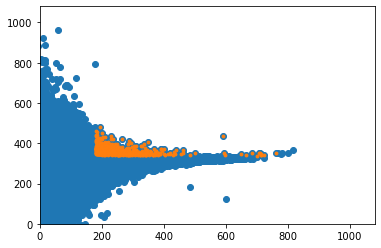

In [13]:
#plot our coordinates with the gated values highlighted
plt.scatter(xcoords,ycoords)
plt.scatter(xcoords[ingate],ycoords[ingate],s=8)
plt.xlim(0,1080)
plt.ylim(0,1080)
plt.show()

In [14]:
#note that this display doesn't exclude values outside the margins, hence the shift from the left side

In [15]:
chnames2,data2,meta2=importflowcyte.getFCSFile('A7.fcs')
fcsdf2=pd.DataFrame(data2.T)
fcsdf2.columns=chnames2
fcsdf2.head()

FCS3.0
[58, 3264, 3265, 5548944, 0, 0]


,T0,T1,INFO,FS00-H,FS00-A,FS00-W,FS01-H,FS01-A,FS01-W,SS02-H,...,FL10-H,FL10-A,FL10-W,FL13-H,FL13-A,FL13-W,FL17-H,FL17-A,FL17-W,TIME
0,1.131441e+09,1.0,1841920.0,243641344.0,276663808.0,690323456.0,1.370563e+09,1.918996e+09,8.564572e+08,99409664.0,...,22655488.0,25860260.00,684163072.0,27055104.0,31378944.0,706183168.0,308224.0,226560.0,166199296.0,10852817.0
1,1.131447e+09,1.0,1841920.0,118849792.0,138411008.0,706838528.0,6.904023e+08,1.013809e+09,9.588900e+08,95149312.0,...,4738816.0,5354227.00,692617216.0,6124544.0,6793472.0,635600896.0,296448.0,271872.0,325025792.0,10852829.0
2,1.131457e+09,1.0,1841920.0,278258176.0,379098368.0,844234752.0,1.316390e+09,2.103820e+09,1.052410e+09,256302080.0,...,13003776.0,16020497.00,756809728.0,16745984.0,19778816.0,727252992.0,877824.0,1040128.0,642252800.0,10852849.0
3,1.131464e+09,1.0,1841920.0,131810048.0,156323840.0,698220544.0,1.150766e+09,1.846821e+09,1.009910e+09,61808128.0,...,6010112.0,6591571.00,645988352.0,7344896.0,8107776.0,676036608.0,96512.0,42240.0,157351936.0,10852864.0
4,1.131481e+09,1.0,1841920.0,120316672.0,153921024.0,746258432.0,1.170851e+09,1.634138e+09,8.819835e+08,89509120.0,...,3702528.0,4188114.25,706641920.0,5394432.0,5417728.0,576782336.0,163072.0,143104.0,355729408.0,10852895.0


In [16]:
fcsdf2['FRET']=fcsdf2['FL04-A']/fcsdf2['FL10-A']
fcsdf2['Acceptor']=fcsdf2['FL10-A']/1000000.0

In [17]:
fig2,figimg2=drawHist(fcsdf2,'Acceptor','FRET',limits=[1.0,2500.0,-0.2,1.0],logs=[True,False])

In [19]:
viewer=napari.Viewer()
viewer.theme='light'
viewer.add_image(figimg2,blending='opaque',interpolation='bilinear',name='test2')

<Image layer 'test2' at 0x240983dc688>

In [20]:
gate2=viewer.layers[-1].data[0]
ingate2,xcoords2,ycoords2=gfc.plotGateContains(fcsdf2['Acceptor'],fcsdf2['FRET'],gate2,limits=[1.0,2500.0,-0.2,1.0],logs=[True,False])

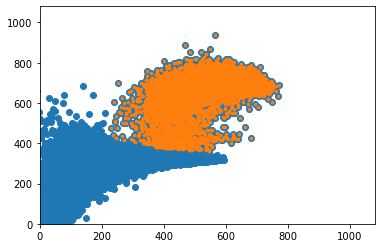

In [21]:
#plot our coordinates with the gated values highlighted
plt.scatter(xcoords2,ycoords2)
plt.scatter(xcoords2[ingate2],ycoords2[ingate2],s=8)
plt.xlim(0,1080)
plt.ylim(0,1080)
plt.show()